In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import argparse
import sklearn.utils.random as sk_random

## Introducción al dataset

El dataset contiene 5531451 filas, cada una correspondiente a la información de un cliente de la empresa American Express con 190 columnas que brindan información de los clientes. Por motivos de privacidad el significado de los valores de dichas columnas no es brindado por la empresa. Sin embargo en lugar del significado de cada columna se nos proporciona las siguientes categorías según el nombre de las mismas:
- D_* = Variables relacionadas a la delincuencia
- S_* = Variables relacionadas a los gastos
- P_* = Variables relacionadas a los pagos
- B_* = Variables de balances
- R_* = Variables de riesgo

Por último se aclara que todas las variables numéricas están normalizadas y que las siguientes variables son categóricas:

- ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


## Reducción del dataset

Debido a la gran cantidad de información del dataset y por lo tanto peso del mismo, se redujo la cantidad de filas en un 5%. De esta forma y redondeando el resultado se plantea trabajar con un dataset que contenga unas 276572 filas.
El procedimiento utilizado para la reducción del dataset es el provisto por la función sample_without_replacement de la libreria scikit-learn. Como parámetros de la misma se utilizó:
- La cantidad de filas totales del dataset(n_population) = 5531451
- La cantidad de filas que se desean obtener(n_samples) = 276572
- Valor semilla (random_state) = 576

*Aclaración: Este último valor se calculó como el resto obtenido al realizar la siguiente división con la multiplicación de una constante por el número del grupo (11) como numerador y a 1000 como denominador $\frac{31416 * 11}{1000}$*

## a) Visualización de los datos:

In [3]:
df_reducido = pd.read_parquet('/kaggle/input/train-data/result_2')

In [4]:
df_reducido.shape

(276572, 191)

In [5]:
df_reducido

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0.001082,0.001930,1.007504,0.001772,0.100470,0.004626,0.006073,...,NaN,NaN,0.003611,0.009607,0.007266,NaN,0.008763,0.004753,0.009068,0
88,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-01-11,0.414444,0.006512,0.100998,0.055903,0.000040,0.333741,0.007850,0.174713,...,NaN,NaN,0.002959,0.006169,0.007130,NaN,0.002450,0.007935,0.009131,0
113,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-12-17,0.408131,0.097428,0.932366,0.020943,0.008163,0.166899,0.004582,1.163413,...,NaN,NaN,1.002598,0.000091,0.870157,0.173529,1.003708,0.007586,0.733164,1
129,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,2018-03-16,0.359892,0.009807,0.090679,0.818198,0.507561,0.182016,0.002933,0.009862,...,NaN,NaN,0.009808,0.002212,0.004070,NaN,0.005430,0.007106,0.006270,1
137,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,2017-07-01,0.311111,0.592908,0.096867,0.040793,0.002294,0.460324,0.009938,0.223131,...,NaN,NaN,0.001164,0.001779,0.004852,NaN,0.006252,0.008367,0.005460,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531343,fffec7d7e1ca804c86f1ffdaac389c33f8039ed35bf412...,2018-02-17,0.703939,0.004059,0.008331,0.811022,0.002205,NaN,0.003142,0.007565,...,NaN,NaN,0.001089,0.005771,0.000978,NaN,0.003419,0.000885,0.009094,0
5531392,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,2017-09-09,0.895553,0.002237,0.028992,1.003776,0.006711,0.140112,0.007834,0.002409,...,NaN,NaN,0.009965,0.007940,0.002403,NaN,0.001129,0.008662,0.007075,0
5531413,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2017-04-23,0.780039,0.001232,0.162431,0.004150,0.000303,0.086377,0.629556,0.004347,...,NaN,NaN,0.000827,0.004853,0.009224,NaN,0.007942,0.002397,0.008535,0
5531422,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,2018-01-11,0.794548,0.384731,0.027101,1.001420,0.005396,0.075824,0.000377,0.004891,...,NaN,NaN,NaN,0.000498,NaN,NaN,NaN,0.004904,NaN,0


In [6]:
df_reducido['target'].value_counts()

0    207712
1     68860
Name: target, dtype: int64

### Tipos de variables

In [7]:
df_reducido.dtypes.value_counts()

float64    185
object       4
int64        2
dtype: int64

Analizamos el tipo de las variables para conocer más de las mismas y determinar si serán de utilidad, o en su defecto si se debe realizar algún procedimiento para su modificación o eliminación.
Sabemos que las variables normalizadas pertenecen a la categoría “float64” y resulta de interés el análisis de las variables de tipo “object” u objetos y las variables “int” o enteras. 
- Las variables de tipo objeto son las columnas “customer_ID”,”S_2”,”D_63” y “D_64”
- Las variables de tipo entero son las columnas “target” y “B_31”

Se mostraran sus valores y se decidirá en base a los mismos que acciones tomar al momento de modificar el dataset.

In [8]:
df_reducido.loc[:,'S_2'] 

9          2017-12-04
88         2018-01-11
113        2017-12-17
129        2018-03-16
137        2017-07-01
              ...    
5531343    2018-02-17
5531392    2017-09-09
5531413    2017-04-23
5531422    2018-01-11
5531442    2017-07-20
Name: S_2, Length: 276572, dtype: object

In [9]:
df_reducido['S_2'].isna().sum()

0

In [10]:
df_reducido.loc[:,'B_31']

9          1
88         1
113        1
129        1
137        1
          ..
5531343    1
5531392    1
5531413    1
5531422    1
5531442    1
Name: B_31, Length: 276572, dtype: int64

In [11]:
df_reducido['B_31'].isna().sum()

0

In [12]:
df_reducido.loc[:,'D_63']

9          CR
88         CO
113        CO
129        CO
137        CO
           ..
5531343    CO
5531392    CO
5531413    CO
5531422    CO
5531442    CL
Name: D_63, Length: 276572, dtype: object

In [13]:
df_reducido['D_63'].isna().sum()

0

In [14]:
df_reducido.loc[:,'D_64']

9          O
88         R
113        U
129        O
137        O
          ..
5531343    R
5531392    U
5531413    U
5531422    U
5531442    O
Name: D_64, Length: 276572, dtype: object

In [15]:
df_reducido['D_64'].isna().sum()

10966

### Categorias de las variables

In [16]:
columns = df_reducido.columns

sum_types = [0,0,0,0,0] # [type_D ,type_S,type_P,type_B, type_R ]

for column in columns:
    if (column[0] == 'D'):
        sum_types[0] += 1
    elif (column[0] == 'S'):
        sum_types[1] += 1
    elif (column[0] == 'P'):
        sum_types[2] += 1
    elif (column[0] == 'B'):
        sum_types[3] += 1
    elif (column[0] == 'R'):
        sum_types[4] += 1
sum_types

[96, 22, 3, 40, 28]

Observamos que en nuestro dataset reducido tenemos cantidades significativamente diferentes de cada tipo de variable, siendo 96 variables relacionadas a la delincuencia, 22 relacionadas a los gastos, 3 relacionadas a los pagos, 40 de balances y 28 variables de riesgo. Sumando un total 189 columnas donde se excluyen a dos variables ('customer_ID' y 'target') para completar las 191 variables tal y como se mostró anteriormente al realizar shape sobre el dataset.

In [17]:
df_reducido.sort_index(axis = 1, inplace = True)
df_reducido

,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,...,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9,customer_ID,target
9,0.001930,0.431864,0.004027,0.112579,0.074886,0.009725,0.007219,0.000227,NaN,1.007369,...,0.022741,0.816651,0.100470,0.007165,0.002629,0.074646,0.759416,0.019340,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
88,0.100998,0.020843,0.065763,0.011516,0.011943,0.023915,0.002677,0.752512,NaN,0.245604,...,0.007319,0.003056,0.333741,0.007118,0.003323,0.449327,0.121571,NaN,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0
113,0.932366,0.006830,0.938222,0.018259,0.011526,0.310057,0.007449,1.005576,0.958476,0.100295,...,0.005956,NaN,0.166899,0.023294,1.001347,0.195864,0.469173,NaN,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,1
129,0.090679,0.010080,0.061696,0.009170,0.022505,0.021193,0.005326,0.004090,NaN,0.483923,...,0.001798,0.006840,0.182016,0.054562,1.005409,0.283636,0.252979,NaN,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,1
137,0.096867,0.016876,0.072356,0.015320,0.032634,0.030532,0.003829,0.500069,0.008569,0.184785,...,0.004177,0.004812,0.460324,0.042095,0.009332,0.568983,0.328557,NaN,00013c6e1cec7c21bede7cb319f1e28eb994f5625257f4...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531343,0.008331,0.242958,0.004117,0.003937,0.006548,0.004503,0.003287,0.003259,NaN,1.004954,...,0.002313,NaN,NaN,0.000499,1.004101,NaN,0.006319,NaN,fffec7d7e1ca804c86f1ffdaac389c33f8039ed35bf412...,0
5531392,0.028992,0.453770,0.017547,0.224241,0.239149,0.101930,0.009882,0.002982,NaN,1.009120,...,0.055105,0.006036,0.140112,0.275520,0.009312,0.094025,0.492496,NaN,ffff41c8a52833b56430603969b9ca48d208e7c192c6a4...,0
5531413,0.162431,0.134409,0.135216,0.023709,0.086869,0.073229,0.001598,0.335726,0.880369,0.379636,...,0.003040,0.430051,0.086377,0.133227,0.000729,0.087364,0.666838,0.035156,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0
5531422,0.027101,0.293564,0.010437,0.064097,0.049037,0.025647,0.005012,0.335705,NaN,1.007944,...,0.008761,0.380321,0.075824,0.060779,0.008526,0.048874,0.704418,0.022882,ffff9984b999fccb2b6127635ed0736dda94e544e67e02...,0


### Correlación entre variables

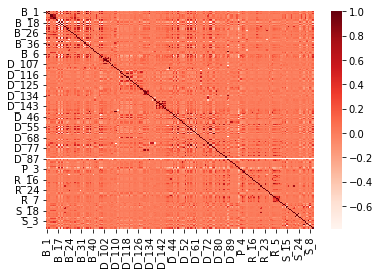

In [18]:
sns.heatmap(df_reducido.corr(method='pearson'), cmap='Reds')

Del heatmap obtenido se pueden observar ciertas correlaciones, siendo muchas de estas con un color intenso (indicando un gran nivel de correlación) con variables de su mismo “tipo” según las categorías presentadas al inicio del trabajo (D, S, P, B, R). Esto nos indica que existe la posibilidad de realizar una reducción de la dimensionalidad de los datos sin perder información, lo cual será profundizado más adelante en el trabajo.
Paralelamente observamos que existe una “Cruz” creada por una línea vertical y una horizontal de color blanco indicando que la variable D_87 no posee ninguna correlación con ninguna otra variable. Esta situación es causada por la cantidad de datos Nan que posee esta columna (mostrado a continuación), más adelante en el trabajo se trabajara sobre los datos faltantes y se tomaran acciones sobre los mismos.


In [19]:
df_reducido.loc[:,'D_87']

9         NaN
88        NaN
113       NaN
129       NaN
137       NaN
           ..
5531343   NaN
5531392   NaN
5531413   NaN
5531422   NaN
5531442   NaN
Name: D_87, Length: 276572, dtype: float64

### Relacion de variables con el target

In [20]:
import matplotlib.pyplot as plt

In [21]:
df_reducido['D_63'].value_counts()

CO    205972
CR     46499
CL     21933
XZ      1292
XM       526
XL       350
Name: D_63, dtype: int64

In [22]:
deuda_D_63 = df_reducido.loc[:, ['target', 'D_63']].groupby(['D_63'])['target'].value_counts().unstack()
deuda_D_63

target,0,1
D_63,,
CL,15652,6281
CO,151806,54166
CR,38603,7896
XL,224,126
XM,386,140
XZ,1041,251


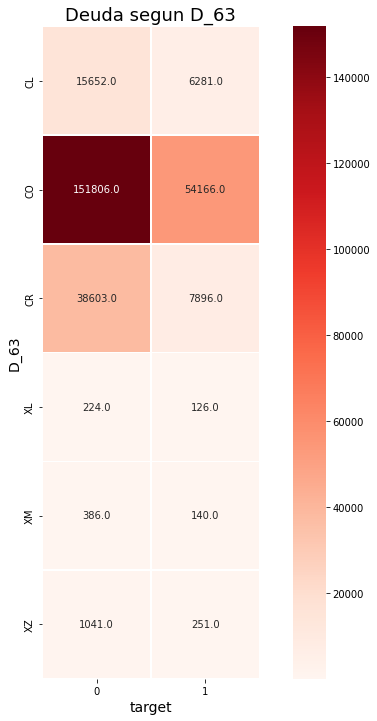

In [23]:
plt.figure(figsize=(12,12))
plt.xlabel('Deuda', size = 14)
plt.ylabel('D_63', size = 14)
plt.title('Deuda segun D_63', size = 18)
sns.heatmap(deuda_D_63, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds')

In [24]:
df_reducido['B_31'].value_counts()

1    275714
0       858
Name: B_31, dtype: int64

In [25]:
df_reducido['D_64'].value_counts()

O     145585
U      76041
R      42167
-1      1813
Name: D_64, dtype: int64

In [26]:
deuda_D_64 = df_reducido.loc[:, ['target', 'D_64']].groupby(['D_64'])['target'].value_counts().unstack()
deuda_D_64

target,0,1
D_64,,
-1,1425,388
O,121041,24544
R,28832,13335
U,49999,26042


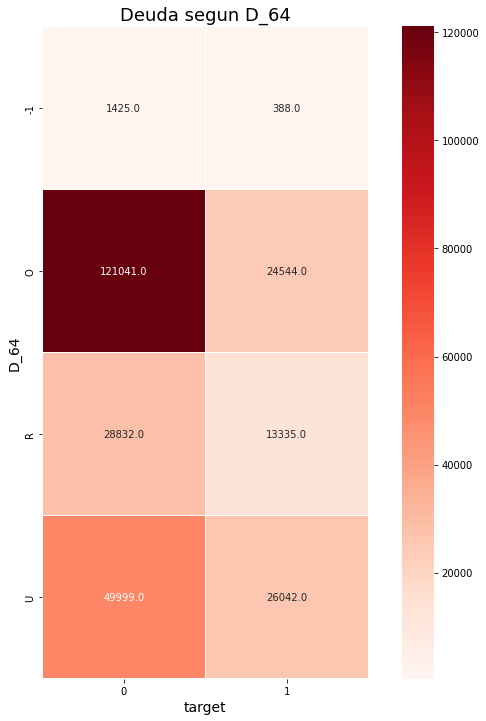

In [27]:
plt.figure(figsize=(12,12))
plt.xlabel('Deuda', size = 14)
plt.ylabel('D_64', size = 14)
plt.title('Deuda segun D_64', size = 18)
sns.heatmap(deuda_D_64, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds')

Análisis de la variable "S_2"; la idea es ver si la fecha de cada transacción se relaciona de alguna manera con el objetivo, y si aporta información relevante. De no ser así, se podrá eliminar esta columna.

In [28]:
df_reducido['S_2'] = pd.to_datetime(df_reducido['S_2'], format='%Y-%m-%d')
df_reducido['S_2']

9         2017-12-04
88        2018-01-11
113       2017-12-17
129       2018-03-16
137       2017-07-01
             ...    
5531343   2018-02-17
5531392   2017-09-09
5531413   2017-04-23
5531422   2018-01-11
5531442   2017-07-20
Name: S_2, Length: 276572, dtype: datetime64[ns]

In [29]:
df_reducido['year'] = pd.DatetimeIndex(df_reducido['S_2']).year
df_reducido['year']

9          2017
88         2018
113        2017
129        2018
137        2017
           ... 
5531343    2018
5531392    2017
5531413    2017
5531422    2018
5531442    2017
Name: year, Length: 276572, dtype: int64

In [30]:
df_reducido['year'].value_counts()

2017    208500
2018     68072
Name: year, dtype: int64

In [31]:
year_target = df_reducido.groupby(['year'])['target'].sum().reset_index()
year_target

,year,target
0,2017,51088
1,2018,17772


Text(0, 0.5, 'Número de pagos incumplidos')

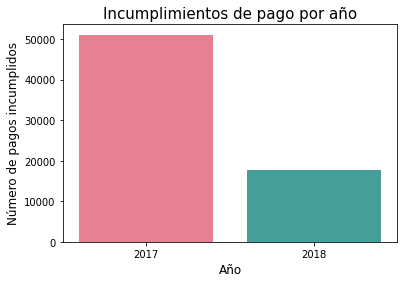

In [32]:
g = sns.barplot(x=year_target.year, y=year_target.target, palette='husl')
g.set_title("Incumplimientos de pago por año", fontsize=15)
g.set_xlabel("Año", fontsize=12)
g.set_ylabel("Número de pagos incumplidos", fontsize=12)

In [33]:
year_2017 = df_reducido.loc[df_reducido['year'] == 2017, ['S_2', 'target']]
year_2017

,S_2,target
9,2017-12-04,0
113,2017-12-17,1
137,2017-07-01,1
153,2017-10-15,1
154,2017-11-19,1
...,...,...
5531330,2017-08-03,0
5531332,2017-10-21,0
5531392,2017-09-09,0
5531413,2017-04-23,0


In [34]:
year_2017['month'] = pd.DatetimeIndex(year_2017['S_2']).month
year_2017['month'].value_counts()

12    22019
10    21667
11    21542
9     21125
8     21017
7     20829
6     20606
4     20117
5     19914
3     19664
Name: month, dtype: int64

In [35]:
months_2017 = year_2017.groupby(['month'])['target'].sum().reset_index()
months_2017

,month,target
0,3,4606
1,4,4598
2,5,4787
3,6,4958
4,7,5099
5,8,5194
6,9,5348
7,10,5450
8,11,5390
9,12,5658


Text(0, 0.5, 'Número de pagos incumplidos')

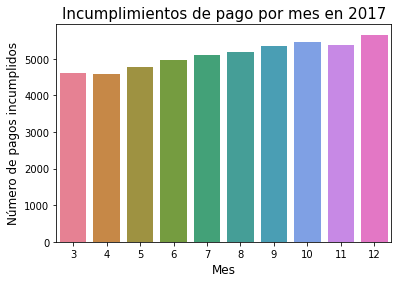

In [36]:
g = sns.barplot(x=months_2017.month, y=months_2017.target, palette='husl')
g.set_title("Incumplimientos de pago por mes en 2017", fontsize=15)
g.set_xlabel("Mes", fontsize=12)
g.set_ylabel("Número de pagos incumplidos", fontsize=12)

In [37]:
year_2018 = df_reducido.loc[df_reducido['year'] == 2018, ['S_2', 'target']]
year_2018

,S_2,target
88,2018-01-11,0
129,2018-03-16,1
144,2018-02-10,1
145,2018-03-13,1
290,2018-01-20,0
...,...,...
5531118,2018-01-27,0
5531257,2018-01-17,1
5531310,2018-02-17,0
5531343,2018-02-17,0


In [38]:
year_2018['month'] = pd.DatetimeIndex(year_2018['S_2']).month
year_2018['month'].value_counts()

3    22889
2    22784
1    22399
Name: month, dtype: int64

In [39]:
months_2018 = year_2018.groupby(['month'])['target'].sum().reset_index()
months_2018

,month,target
0,1,5810
1,2,5990
2,3,5972


Text(0, 0.5, 'Número de pagos incumplidos')

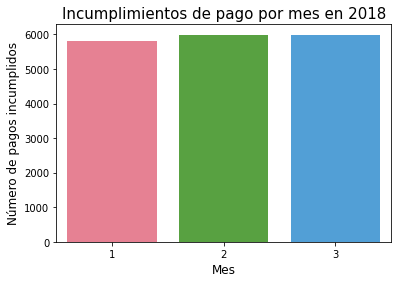

In [40]:
g = sns.barplot(x=months_2018.month, y=months_2018.target, palette='husl')
g.set_title("Incumplimientos de pago por mes en 2018", fontsize=15)
g.set_xlabel("Mes", fontsize=12)
g.set_ylabel("Número de pagos incumplidos", fontsize=12)

En ambos años se ve un pequeño crecimiento de incumplimiento de pagos al pasar los meses. En enero de 2018 hubieron mas incumplimientos que en diciembre de 2017. Es decir, cada vez se cumplen menos los pagos de las deudas al pasar el tiempo. Esto también se puede deber a que aumentaron los clientes. Habría que analizar la proporción de aumento de clientes con el aumento de los incumplimientos de pago.

In [41]:
df_reducido.drop(columns=['year'], inplace=True)

## b) Ingeniería de características

Eliminamos la variable "customer_ID" ya que no aporta información relevante que ayude a predecir el target

In [42]:
df_reducido.drop(columns=['customer_ID'], inplace=True)
df_reducido.head()

,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,...,S_25,S_26,S_27,S_3,S_5,S_6,S_7,S_8,S_9,target
9,0.001930,0.431864,0.004027,0.112579,0.074886,0.009725,0.007219,0.000227,NaN,1.007369,...,0.969777,0.022741,0.816651,0.100470,0.007165,0.002629,0.074646,0.759416,0.01934,0
88,0.100998,0.020843,0.065763,0.011516,0.011943,0.023915,0.002677,0.752512,NaN,0.245604,...,0.554076,0.007319,0.003056,0.333741,0.007118,0.003323,0.449327,0.121571,NaN,0
113,0.932366,0.006830,0.938222,0.018259,0.011526,0.310057,0.007449,1.005576,0.958476,0.100295,...,0.977311,0.005956,NaN,0.166899,0.023294,1.001347,0.195864,0.469173,NaN,1
129,0.090679,0.010080,0.061696,0.009170,0.022505,0.021193,0.005326,0.004090,NaN,0.483923,...,0.970850,0.001798,0.006840,0.182016,0.054562,1.005409,0.283636,0.252979,NaN,1
137,0.096867,0.016876,0.072356,0.015320,0.032634,0.030532,0.003829,0.500069,0.008569,0.184785,...,0.101208,0.004177,0.004812,0.460324,0.042095,0.009332,0.568983,0.328557,NaN,1


In [43]:
columns = df_reducido.drop(columns=['B_31','D_63', 'D_64', 'S_2','target']).columns
for column in columns:
  mean = np.mean(df_reducido[column])
  df_reducido[column].fillna(mean, inplace=True)

In [44]:
df_reducido.drop(columns=['B_31','D_63', 'D_64', 'S_2','target']).isna().sum().sum()

0

In [45]:
import scipy.stats as st

In [46]:
columns = df_reducido.drop(columns=['B_31','D_63', 'D_64', 'S_2','target']).columns
zscore_df = pd.DataFrame()
column_name = 'z_'
for column in columns:
  zscore_df[column_name + column] = st.zscore(df_reducido[column])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


In [47]:
zscore_df.head()

,z_B_1,z_B_10,z_B_11,z_B_12,z_B_13,z_B_14,z_B_15,z_B_16,z_B_17,z_B_18,...,z_S_24,z_S_25,z_S_26,z_S_27,z_S_3,z_S_5,z_S_6,z_S_7,z_S_8,z_S_9
9,-0.574047,0.020524,-0.513082,0.030358,-0.046137,-0.304307,-0.142637,-0.866441,-4.355433e-16,1.124610,...,0.213902,0.215360,-0.088819,1.909165e+00,-0.719314,-0.223435,-0.565221,-0.797454,1.427448,-4.096655e-01
88,-0.107459,-0.024294,-0.216469,-0.130120,-0.156979,-0.257150,-0.156740,1.004687,-4.355433e-16,-0.960280,...,0.273972,-1.817146,-0.119731,-9.718548e-01,0.618477,-0.223565,-0.563593,1.215488,-0.680034,1.010724e-16
113,3.808099,-0.025822,3.975275,-0.119413,-0.157713,0.693775,-0.141925,1.634122,9.554324e-01,-1.357978,...,0.213238,0.252194,-0.122462,-1.965705e-16,-0.338345,-0.178391,1.778186,-0.146220,0.468468,1.010724e-16
129,-0.156060,-0.025468,-0.236008,-0.133845,-0.138379,-0.266196,-0.148515,-0.856832,-4.355433e-16,-0.308019,...,0.244896,0.220604,-0.130797,-9.584548e-01,-0.251652,-0.091077,1.787718,0.325328,-0.245852,1.010724e-16
137,-0.126915,-0.024727,-0.184794,-0.124079,-0.120543,-0.235161,-0.153163,0.376796,-2.771077e+00,-1.126735,...,0.265218,-4.031378,-0.126027,-9.656372e-01,1.344422,-0.125889,-0.549494,1.858333,0.003863,1.010724e-16


In [48]:
outliers_df = pd.DataFrame()
for column in zscore_df.columns:
  if (sum(zscore_df[column].values > 3) > 0) or (sum(zscore_df[column].values < -3) > 0):
    outliers_df[column] = zscore_df[column]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [49]:
outliers_df.head(10)

,z_B_1,z_B_10,z_B_11,z_B_12,z_B_13,z_B_14,z_B_15,z_B_21,z_B_22,z_B_23,...,z_S_22,z_S_23,z_S_24,z_S_25,z_S_26,z_S_27,z_S_3,z_S_5,z_S_7,z_S_9
9,-0.574047,0.020524,-0.513082,0.030358,-0.046137,-0.304307,-0.142637,-0.069474,-0.439618,-0.725876,...,0.171065,-0.090256,0.213902,0.215360,-0.088819,1.909165e+00,-0.719314,-0.223435,-0.797454,-4.096655e-01
88,-0.107459,-0.024294,-0.216469,-0.130120,-0.156979,-0.257150,-0.156740,-0.064188,-0.461158,-0.596218,...,0.260030,0.624889,0.273972,-1.817146,-0.119731,-9.718548e-01,0.618477,-0.223565,1.215488,1.010724e-16
113,3.808099,-0.025822,3.975275,-0.119413,-0.157713,0.693775,-0.141925,-0.066677,1.767393,2.559907,...,0.208813,-0.081009,0.213238,0.252194,-0.122462,-1.965705e-16,-0.338345,-0.178391,-0.146220,1.010724e-16
129,-0.156060,-0.025468,-0.236008,-0.133845,-0.138379,-0.266196,-0.148515,-0.073012,-0.464056,3.023978,...,0.205472,-0.088218,0.244896,0.220604,-0.130797,-9.584548e-01,-0.251652,-0.091077,0.325328,1.010724e-16
137,-0.126915,-0.024727,-0.184794,-0.124079,-0.120543,-0.235161,-0.153163,-0.073924,1.791386,1.101818,...,0.270682,0.427260,0.265218,-4.031378,-0.126027,-9.656372e-01,1.344422,-0.125889,1.858333,1.010724e-16
144,-0.057421,-0.025742,-0.170776,-0.136550,-0.156169,-0.251838,-0.161776,-0.064835,1.791781,2.064719,...,0.260664,0.552877,0.258593,-2.763354,-0.129798,-9.705291e-01,1.784864,-0.008848,1.163096,1.010724e-16
145,-0.111378,-0.025394,-0.226356,-0.138578,-0.167278,-0.248829,-0.160585,-0.063371,-0.458713,2.041291,...,0.241611,0.569193,0.247648,-3.086934,-0.118320,-9.810527e-01,1.538347,-0.042986,0.863993,1.010724e-16
153,3.895700,-0.026066,4.042008,-0.127129,-0.153601,0.662741,-0.154288,-0.066006,1.766369,4.212937,...,0.219268,-0.084626,0.237150,0.228692,-0.122561,-9.591461e-01,-0.110763,-0.204349,-0.114938,1.010724e-16
154,3.453772,-0.025555,3.606389,-0.129959,-0.171665,0.607730,-0.154669,-0.065085,4.017693,4.147176,...,0.240002,-0.088882,0.241185,0.246424,-0.115875,-9.770889e-01,-0.049068,-0.241198,0.029755,1.010724e-16
160,-0.487090,0.005462,-0.483431,-0.061750,-0.074589,-0.278675,-0.148020,-0.074742,-0.470933,-0.641378,...,0.221366,-0.072632,0.234761,0.214918,0.116354,1.034308e+00,-0.549412,-0.152557,-0.620584,-5.332532e-01


### Transformación de variables

Se transforman las columnas categóricas a numéricas para poder trabajar con ellas con los modelos que las requieran

In [55]:
dummies_cols = ['D_63', 'D_64']
df_reducido_dummies = pd.get_dummies(df_reducido, columns=dummies_cols)
df_reducido_dummies.head(10)

,B_1,B_10,B_11,B_12,B_13,B_14,B_15,B_16,B_17,B_18,...,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_-1,D_64_O,D_64_R,D_64_U
9,0.001930,0.431864,0.004027,0.112579,0.074886,0.009725,0.007219,0.000227,0.714931,1.007369,...,0,0,1,0,0,0,0,1,0,0
88,0.100998,0.020843,0.065763,0.011516,0.011943,0.023915,0.002677,0.752512,0.714931,0.245604,...,0,1,0,0,0,0,0,0,1,0
113,0.932366,0.006830,0.938222,0.018259,0.011526,0.310057,0.007449,1.005576,0.958476,0.100295,...,0,1,0,0,0,0,0,0,0,1
129,0.090679,0.010080,0.061696,0.009170,0.022505,0.021193,0.005326,0.004090,0.714931,0.483923,...,0,1,0,0,0,0,0,1,0,0
137,0.096867,0.016876,0.072356,0.015320,0.032634,0.030532,0.003829,0.500069,0.008569,0.184785,...,0,1,0,0,0,0,0,1,0,0
144,0.111622,0.007562,0.075273,0.007467,0.012403,0.025514,0.001055,1.007441,0.954891,0.121565,...,0,1,0,0,0,0,0,1,0,0
145,0.100166,0.010755,0.063705,0.006189,0.006094,0.026419,0.001439,1.009049,1.007422,0.121258,...,0,1,0,0,0,0,0,1,0,0
153,0.950966,0.004594,0.952112,0.013399,0.013861,0.300718,0.003467,1.006890,0.936970,0.004914,...,0,1,0,0,0,0,0,0,0,1
154,0.857134,0.009281,0.861443,0.011617,0.003603,0.284165,0.003344,1.006082,0.976464,0.005569,...,0,1,0,0,0,0,0,0,0,1
160,0.020393,0.293732,0.010198,0.054573,0.058729,0.017438,0.005486,0.169487,0.714931,1.009019,...,0,1,0,0,0,0,0,0,0,1
